## Import Libraries & Setup

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set(style="whitegrid")

## Load Dataset

In [2]:
train = pd.read_csv('/kaggle/input/py-sphere-movie-review-sentiment-challenge/train.csv')
test = pd.read_csv('/kaggle/input/py-sphere-movie-review-sentiment-challenge/test.csv')

## Basic Info

In [3]:
print(train.shape, test.shape)

(1600, 3) (5001, 3)


## EDA 

In [4]:
print(train.head())
print(train['sentiment'].value_counts())
print(train.isna().sum())

train['length'] = train['review'].str.split().apply(lambda x: len(x) if isinstance(x, list) else 0)

     id                                             review  sentiment
0  1861                A masterpiece! Highly recommend it.          1
1   354        The characters were flat and uninteresting.          0
2  1334          Awful visuals and horrible sound quality.          0
3   906  What a fantastic experience, I enjoyed every m...          1
4  1290            I couldn't stop smiling while watching.          1
sentiment
1    801
0    799
Name: count, dtype: int64
id           0
review       0
sentiment    0
dtype: int64


## Data Visualization

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


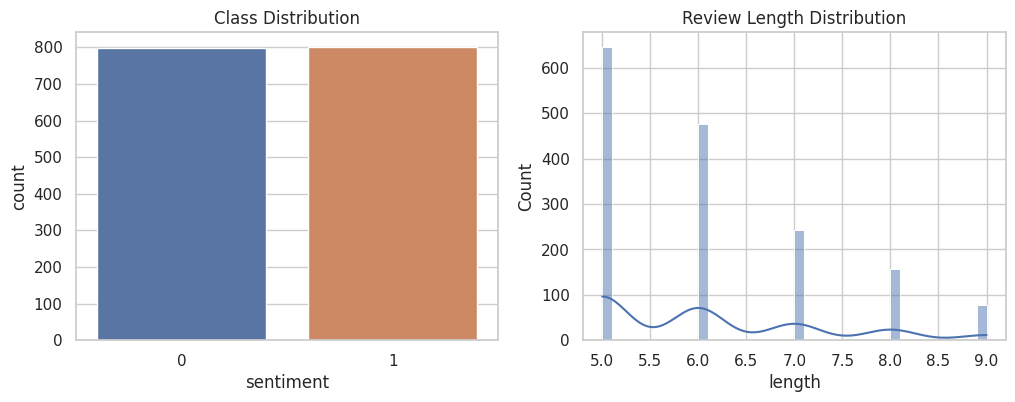

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(data=train, x='sentiment', ax=axes[0])
axes[0].set_title('Class Distribution')

sns.histplot(train['length'], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Review Length Distribution')
plt.show()

## Text Cleaning Function

In [6]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

## Apply Cleaning Function to Dataset

In [7]:
train['clean'] = train['review'].apply(clean_text)
test['clean']  = test['review'].apply(clean_text)

## Split Data into Train & Validation Sets

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    train['clean'], train['sentiment'],
    test_size=0.2, random_state=42, stratify=train['sentiment']
)

## Feature Extraction with TF-IDF

In [9]:
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_vec = tfidf.fit_transform(X_train)
X_val_vec   = tfidf.transform(X_val)
X_test_vec  = tfidf.transform(test['clean'])

## Baseline Model (Majority Class Accuracy)

In [10]:
majority = int(train['sentiment'].mean() >= 0.5)
baseline_acc = (y_val == majority).mean()
print("Baseline (majority) accuracy:", round(baseline_acc, 4))

Baseline (majority) accuracy: 0.5


## Model Training – Logistic Regression

In [11]:
logreg = LogisticRegression(max_iter=2000, C=0.1)
logreg.fit(X_train_vec, y_train)
val_pred_lr = logreg.predict(X_val_vec)
print("LR Val Accuracy:", round(accuracy_score(y_val, val_pred_lr), 4))

LR Val Accuracy: 1.0


## Model Training – Naive Bayes

In [12]:
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
val_pred_nb = nb.predict(X_val_vec)
print("NB Val Accuracy:", round(accuracy_score(y_val, val_pred_nb), 4))

NB Val Accuracy: 1.0


## Model Selection & Evaluation

In [13]:
best_name, best_preds, best_model = (
    ("LR", val_pred_lr, logreg) if accuracy_score(y_val, val_pred_lr) >= accuracy_score(y_val, val_pred_nb)
    else ("NB", val_pred_nb, nb)
)

print(f"Best Model: {best_name}")
print(classification_report(y_val, best_preds))

Best Model: LR
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       160

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320



## Confusion Matrix Visualization

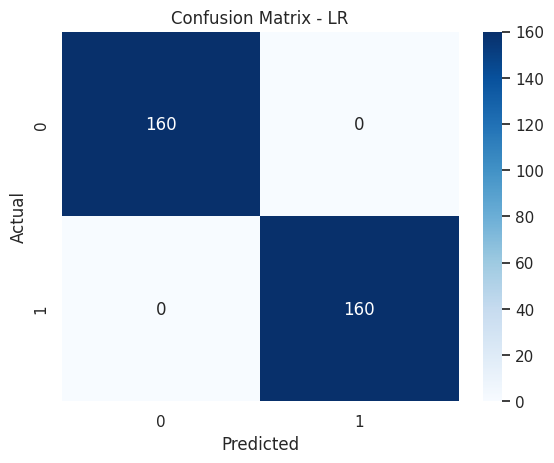

In [14]:
cm = confusion_matrix(y_val, best_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_name}")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

## Cross-Validation for Model Robustness

In [15]:
X_all = tfidf.fit_transform(train['clean'])
cv_scores = cross_val_score(best_model, X_all, train['sentiment'], cv=5, scoring='accuracy')
print("CV Accuracy Mean:", round(cv_scores.mean(), 4), "| Std:", round(cv_scores.std(), 4))

CV Accuracy Mean: 1.0 | Std: 0.0


## Visualization of Predictions

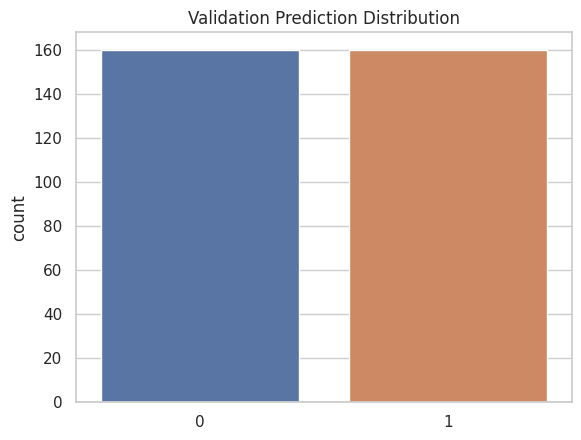

In [16]:
sns.countplot(x=best_preds)
plt.title("Validation Prediction Distribution")
plt.show()

## Final Model Training on Full Data

In [17]:
tfidf_final = TfidfVectorizer(max_features=1000, stop_words='english')
X_full = tfidf_final.fit_transform(train['clean'])
best_final = LogisticRegression(max_iter=2000, C=0.1) if best_name=="LR" else MultinomialNB()
best_final.fit(X_full, train['sentiment'])

LogisticRegression(C=0.1, max_iter=2000)

## Generate Predictions & Create Submission File

In [18]:
X_test_final = tfidf_final.transform(test['clean'])
test_preds = best_final.predict(X_test_final)

submission = pd.DataFrame({"id": test['id'], "sentiment": test_preds})
submission.to_csv("submission.csv", index=False)
print("Saved: submission.csv")

Saved: submission.csv
